# Link Percolation EBE Analysis

- Uses `analysis_utils.py` on `link_percolation/` outputs.
- Separate GC and 2-core observables.
- Includes GC vs p and |C2| vs p plots from averaged NR files.
- 2-core jump height fit uses row 26 (`core_drop`).

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import re
import importlib
import analysis_utils as au

# Reload to pick up local edits when running interactively
importlib.reload(au)

ROOT = Path.cwd()
BASE_DIR = ROOT / 'link_percolation'
FIG_DIR = BASE_DIR / 'figures'

# Save all plots into link_percolation/figures as 1.png, 2.png, ...
au.configure_plot_saving(FIG_DIR, numbered=True, start=1)

# Select strategy folder (must match link_percolation/run_powers.sh)
MODE = 'adaptive'  # adaptive, static, random, adaptive_biased, static_biased, random_biased, random_biased_adaptive
DATA_DIR = BASE_DIR / MODE

# Output prefix basename used in runs (run_powers.sh default is 'LR')
OUTPUT_PREFIX = 'LR'

EBE_PATTERN = f"{OUTPUT_PREFIX}_EBE_*.dat"
NR_PATTERN = f"{OUTPUT_PREFIX}_LR_ER_*.dat"
STATS_PATTERN = f"stats_{OUTPUT_PREFIX}_EBE_*.dat"

# Observables (row indices refer to the EBE column map in analysis_utils.py)
OBS_GC = [('P(p+)', 4), ('P(q0)', 14)]
OBS_CORE = [('|C2|(p*)', 27)]
EFFECTIVE_WINDOW = 4

print('analysis_utils:', au.__file__)
print('MODE:', MODE)
print('DATA_DIR:', DATA_DIR)
print('FIG_DIR:', FIG_DIR)


analysis_utils: /nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py
MODE: adaptive
DATA_DIR: /nfs/nfs2/home/hanlsun/global_removal/link_percolation/adaptive
FIG_DIR: /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures


In [2]:
summary = au.process_all_ebe(DATA_DIR, DATA_DIR, pattern=EBE_PATTERN, ci_radius_filter=None)
summary[['file', 'runs', 'N', 'M_graphs']]


,file,runs,N,M_graphs
0,LR_EBE_LR_ER_N1048576_c4.00_L0_Mg10000_Mr1.dat,10000,1048576,10000
1,LR_EBE_LR_ER_N131072_c4.00_L0_Mg10000_Mr1.dat,10000,131072,10000
2,LR_EBE_LR_ER_N16384_c4.00_L0_Mg10000_Mr1.dat,10000,16384,10000
3,LR_EBE_LR_ER_N2097152_c4.00_L0_Mg10000_Mr1.dat,10000,2097152,10000
4,LR_EBE_LR_ER_N262144_c4.00_L0_Mg10000_Mr1.dat,10000,262144,10000
5,LR_EBE_LR_ER_N32768_c4.00_L0_Mg10000_Mr1.dat,10000,32768,10000
6,LR_EBE_LR_ER_N4194304_c4.00_L0_Mg10000_Mr1.dat,10000,4194304,10000
7,LR_EBE_LR_ER_N524288_c4.00_L0_Mg10000_Mr1.dat,10000,524288,10000
8,LR_EBE_LR_ER_N65536_c4.00_L0_Mg10000_Mr1.dat,10000,65536,10000
9,LR_EBE_LR_ER_N8192_c4.00_L0_Mg10000_Mr1.dat,10000,8192,10000


In [3]:
# Prefer the largest available ensemble per N (avoids duplicate N entries when you have multiple Mg/Mr)
if summary is None or summary.empty:
    stats_files = []
else:
    selected = (
        summary.sort_values(['N', 'runs', 'file'])
        .groupby('N', as_index=False)
        .tail(1)
        .reset_index(drop=True)
    )
    stats_files = [DATA_DIR / f"stats_{name}" for name in selected['file']]
    stats_files = [p for p in stats_files if p.exists()]

stats_files[:3], len(stats_files)


([PosixPath('/nfs/nfs2/home/hanlsun/global_removal/link_percolation/adaptive/stats_LR_EBE_LR_ER_N8192_c4.00_L0_Mg10000_Mr1.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/link_percolation/adaptive/stats_LR_EBE_LR_ER_N16384_c4.00_L0_Mg10000_Mr1.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/link_percolation/adaptive/stats_LR_EBE_LR_ER_N32768_c4.00_L0_Mg10000_Mr1.dat')],
 11)

## P (GC) and |C2| versus removed fraction p (averaged NR files)

In [4]:
nr_files = sorted(DATA_DIR.glob(NR_PATTERN))
nr_files[:3], len(nr_files)


([PosixPath('/nfs/nfs2/home/hanlsun/global_removal/link_percolation/adaptive/LR_LR_ER_N1048576_c4.00_L0_Mg10000_Mr1.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/link_percolation/adaptive/LR_LR_ER_N131072_c4.00_L0_Mg10000_Mr1.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/link_percolation/adaptive/LR_LR_ER_N16384_c4.00_L0_Mg10000_Mr1.dat')],
 11)

Saved: /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures/402.png
Critical thresholds (post-drop): GC=0.510 | 2-core=0.510


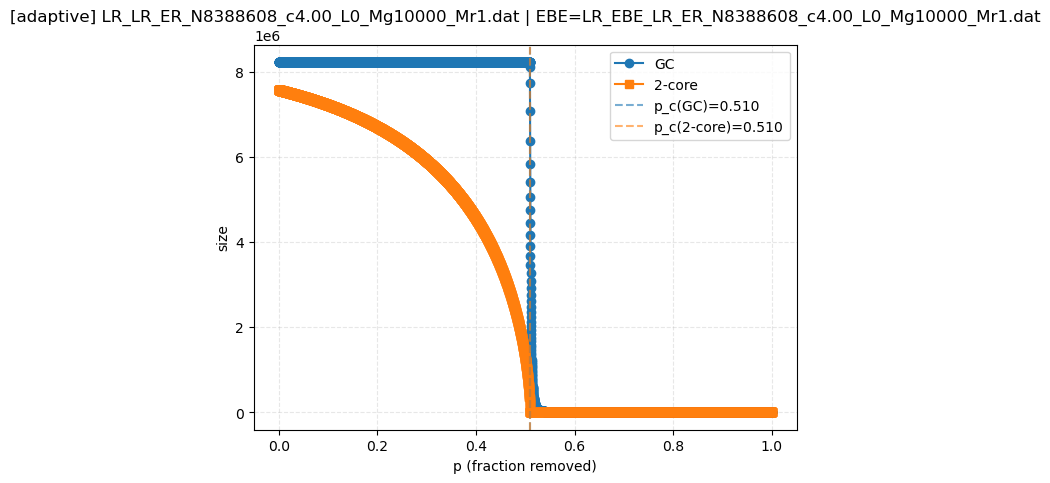

In [5]:
# Plot GC and 2-core for the largest available N (from averaged NR files)

def extract_N(path: Path) -> int:
    m = re.search(r'_N(\d+)_', path.name)
    return int(m.group(1)) if m else -1

def extract_total_runs(path: Path) -> int:
    mg = re.search(r'_Mg(\d+)_', path.name)
    mr = re.search(r'_Mr(\d+)', path.name)
    if not mg or not mr:
        return -1
    return int(mg.group(1)) * int(mr.group(1))

if not nr_files:
    print('No averaged NR files found matching:', NR_PATTERN)
else:
    # Prefer largest N, break ties by largest run count
    largest = max(nr_files, key=lambda p: (extract_N(p), extract_total_runs(p), p.name))
    N_largest = extract_N(largest)
    df = au.read_nr_file(largest)
    if df.empty:
        print(f'{largest.name} is empty')
    else:
        # Use the matching EBE file (same N), prefer the largest run count.
        ebe_files = sorted(DATA_DIR.glob(EBE_PATTERN))
        ebe_match = [p for p in ebe_files if extract_N(p) == N_largest]
        if ebe_match:
            ebe_best = max(ebe_match, key=lambda p: (extract_total_runs(p), p.name))
        else:
            ebe_best = None

        pc_gc = pc_core = None
        if ebe_best is not None:
            ebe_df, _ = au.read_ebe_file(ebe_best)
            if not ebe_df.empty:
                pc_gc = float(ebe_df['p_plus'].mean())
                pc_core = float(ebe_df['core_p_star'].mean())

        fig, ax = plt.subplots(figsize=(7, 5))
        ax.plot(df['p'], df['P_inf'], label='GC', marker='o')
        if 'core' in df.columns and df['core'].notna().any():
            ax.plot(df['p'], df['core'], label='2-core', marker='s')

        if pc_gc is not None:
            ax.axvline(pc_gc, ls='--', color='C0', alpha=0.6, label=f"p_c(GC)={pc_gc:.3f}")
        if pc_core is not None:
            ax.axvline(pc_core, ls='--', color='C1', alpha=0.6, label=f"p_c(2-core)={pc_core:.3f}")

        title = f"[{MODE}] {largest.name}"
        if ebe_best is not None:
            title += f" | EBE={ebe_best.name}"
        ax.set_title(title)
        ax.set_xlabel('p (fraction removed)')
        ax.set_ylabel('size')
        ax.grid(True, ls='--', alpha=0.3)
        ax.legend()

        fig_path = au._save_figure(fig, f"{MODE}_gc_core_N{N_largest}")
        print('Saved:', fig_path)
        if pc_gc is not None or pc_core is not None:
            print(f"Critical thresholds (post-drop): GC={pc_gc:.3f} | 2-core={pc_core:.3f}")
        plt.show()


## Giant Component Observables

In [6]:
fss_gc = {}
fit_gc = {}
for label, row in OBS_GC:
    fss = au.extract_fss(stats_files, row=row, value_kind='mean')
    fss_gc[label] = fss
    fit_gc[label] = au.weighted_log_fit(fss) if not fss.empty else None
fss_gc

{'P(p+)':           N         value         error  \
 0      8192  4.305532e+03     13.707091   
 1     16384  8.610455e+03     27.836369   
 2     32768  1.725961e+04     55.284811   
 3     65536  3.441667e+04    110.700444   
 4    131072  6.917156e+04    221.778539   
 5    262144  1.374323e+05    448.207764   
 6    524288  2.751733e+05    892.566729   
 7   1048576  5.523701e+05   1800.230705   
 8   2097152  1.101029e+06   3594.509109   
 9   4194304  2.206502e+06   7166.872208   
 10  8388608  4.414910e+06  14385.599971   
 
                                                source  L  
 0   stats_LR_EBE_LR_ER_N8192_c4.00_L0_Mg10000_Mr1.dat  0  
 1   stats_LR_EBE_LR_ER_N16384_c4.00_L0_Mg10000_Mr1...  0  
 2   stats_LR_EBE_LR_ER_N32768_c4.00_L0_Mg10000_Mr1...  0  
 3   stats_LR_EBE_LR_ER_N65536_c4.00_L0_Mg10000_Mr1...  0  
 4   stats_LR_EBE_LR_ER_N131072_c4.00_L0_Mg10000_Mr...  0  
 5   stats_LR_EBE_LR_ER_N262144_c4.00_L0_Mg10000_Mr...  0  
 6   stats_LR_EBE_LR_ER_N524288_c4.00_L0_

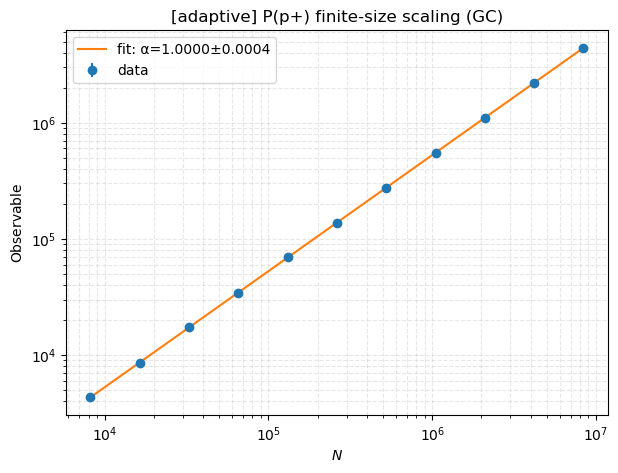

Saved plot to /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures/403.png


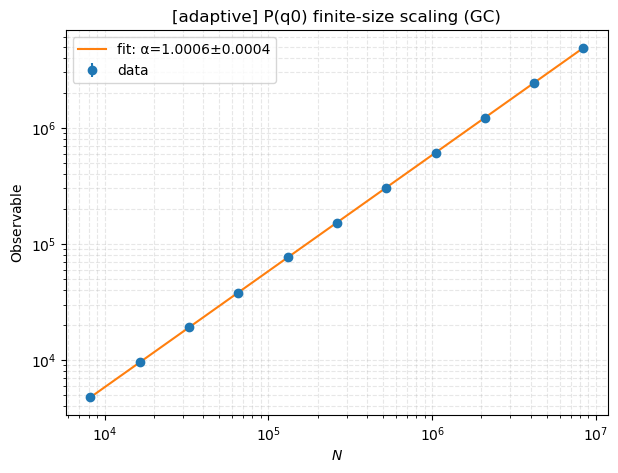

Saved plot to /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures/404.png


In [7]:
for label, _ in OBS_GC:
    fss = fss_gc[label]
    fit = fit_gc[label]
    if fss.empty or fit is None:
        print(f"No data for {label}")
        continue
    au.plot_fss_with_fit(fss, fit, title=f"[{MODE}] {label} finite-size scaling (GC)")


### GC Effective Exponents

In [8]:
eff_gc = {}
for label, _ in OBS_GC:
    fss = fss_gc[label]
    if fss.empty:
        eff_gc[label] = pd.DataFrame()
    else:
        eff_gc[label] = au.compute_effective_exponents(fss, window=EFFECTIVE_WINDOW)
eff_gc

{'P(p+)':       N_left    N_right        N_geom  exponent  exponent_err
 0     8192.0    65536.0  2.317048e+04  0.999982      0.002066
 1    16384.0   131072.0  4.634095e+04  1.001378      0.002077
 2    32768.0   262144.0  9.268190e+04  0.998708      0.002084
 3    65536.0   524288.0  1.853638e+05  0.998799      0.002084
 4   131072.0  1048576.0  3.707276e+05  0.999334      0.002087
 5   262144.0  2097152.0  7.414552e+05  1.001150      0.002105
 6   524288.0  4194304.0  1.482910e+06  1.000525      0.002095
 7  1048576.0  8388608.0  2.965821e+06  0.999893      0.002102,
 'P(q0)':       N_left    N_right        N_geom  exponent  exponent_err
 0     8192.0    65536.0  2.317048e+04  1.001482      0.001888
 1    16384.0   131072.0  4.634095e+04  1.001300      0.001873
 2    32768.0   262144.0  9.268190e+04  1.000017      0.001889
 3    65536.0   524288.0  1.853638e+05  1.000627      0.001891
 4   131072.0  1048576.0  3.707276e+05  1.000984      0.001884
 5   262144.0  2097152.0  7.414552e+

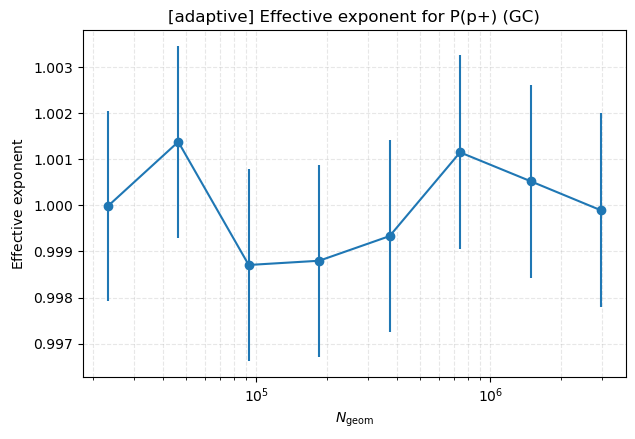

Saved plot to /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures/405.png


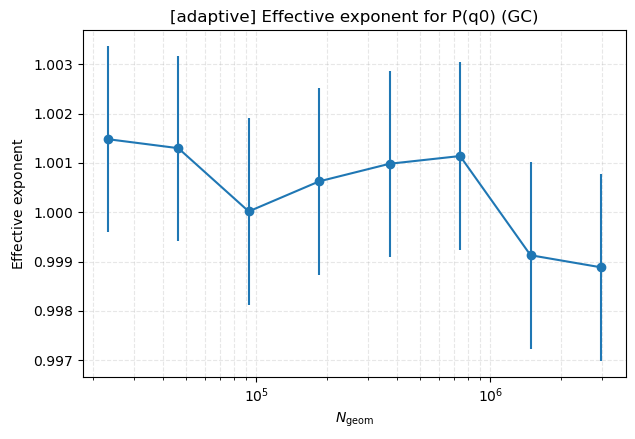

Saved plot to /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures/406.png


In [9]:
for label, eff in eff_gc.items():
    if eff.empty:
        print(f"No effective exponents for {label}")
        continue
    au.plot_effective_exponent(eff, title=f"[{MODE}] Effective exponent for {label} (GC)")


## 2-core Observables

In [10]:
fss_core = {}
fit_core = {}
for label, row in OBS_CORE:
    fss = au.extract_fss(stats_files, row=row, value_kind='mean')
    fss_core[label] = fss
    fit_core[label] = au.weighted_log_fit(fss) if not fss.empty else None
fss_core

{'|C2|(p*)':           N      value      error  \
 0      8192   106.8354   1.285839   
 1     16384   143.5135   1.765855   
 2     32768   185.6390   2.329694   
 3     65536   241.2013   3.020154   
 4    131072   312.5465   4.086812   
 5    262144   395.6914   5.067933   
 6    524288   519.5886   6.975764   
 7   1048576   647.6205   8.450430   
 8   2097152   841.9483  11.154880   
 9   4194304  1054.7268  14.094135   
 10  8388608  1349.0153  17.645876   
 
                                                source  L  
 0   stats_LR_EBE_LR_ER_N8192_c4.00_L0_Mg10000_Mr1.dat  0  
 1   stats_LR_EBE_LR_ER_N16384_c4.00_L0_Mg10000_Mr1...  0  
 2   stats_LR_EBE_LR_ER_N32768_c4.00_L0_Mg10000_Mr1...  0  
 3   stats_LR_EBE_LR_ER_N65536_c4.00_L0_Mg10000_Mr1...  0  
 4   stats_LR_EBE_LR_ER_N131072_c4.00_L0_Mg10000_Mr...  0  
 5   stats_LR_EBE_LR_ER_N262144_c4.00_L0_Mg10000_Mr...  0  
 6   stats_LR_EBE_LR_ER_N524288_c4.00_L0_Mg10000_Mr...  0  
 7   stats_LR_EBE_LR_ER_N1048576_c4.00_L0_Mg10000_

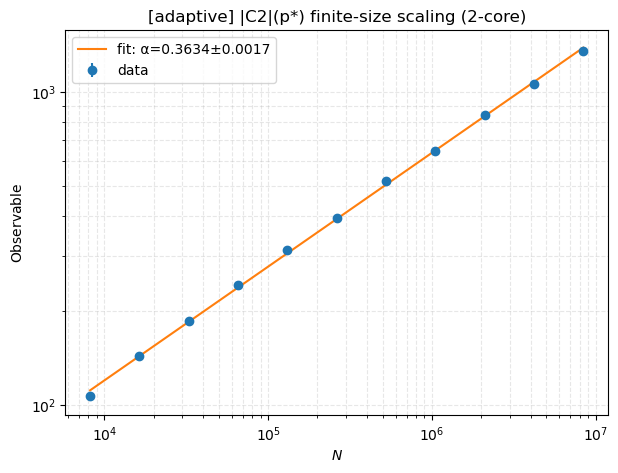

Saved plot to /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures/407.png


In [11]:
for label, _ in OBS_CORE:
    fss = fss_core[label]
    fit = fit_core[label]
    if fss.empty or fit is None:
        print(f"No data for {label}")
        continue
    au.plot_fss_with_fit(fss, fit, title=f"[{MODE}] {label} finite-size scaling (2-core)")


### 2-core Effective Exponents

In [12]:
eff_core = {}
for label, _ in OBS_CORE:
    fss = fss_core[label]
    if fss.empty:
        eff_core[label] = pd.DataFrame()
    else:
        eff_core[label] = au.compute_effective_exponents(fss, window=EFFECTIVE_WINDOW)
eff_core

{'|C2|(p*)':       N_left    N_right        N_geom  exponent  exponent_err
 0     8192.0    65536.0  2.317048e+04  0.389867      0.007931
 1    16384.0   131072.0  4.634095e+04  0.374623      0.008174
 2    32768.0   262144.0  9.268190e+04  0.364962      0.008188
 3    65536.0   524288.0  1.853638e+05  0.365935      0.008362
 4   131072.0  1048576.0  3.707276e+05  0.354534      0.008431
 5   262144.0  2097152.0  7.414552e+05  0.358800      0.008417
 6   524288.0  4194304.0  1.482910e+06  0.344427      0.008625
 7  1048576.0  8388608.0  2.965821e+06  0.350201      0.008444}

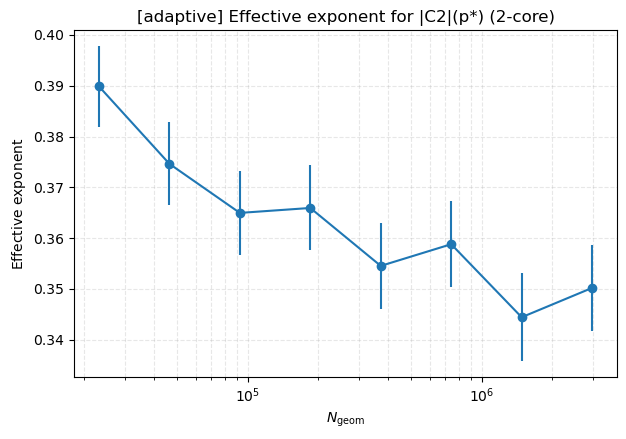

Saved plot to /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures/408.png


In [13]:
for label, eff in eff_core.items():
    if eff.empty:
        print(f"No effective exponents for {label}")
        continue
    au.plot_effective_exponent(eff, title=f"[{MODE}] Effective exponent for {label} (2-core)")


## 2-core Jump Height at p*

          N     value     error
0      8192   53.2620  0.148204
1     16384   67.8620  0.190708
2     32768   86.1214  0.232961
3     65536  109.0158  0.291949
4    131072  138.9337  0.381807
5    262144  176.0159  0.478772
6    524288  221.9747  0.592748
7   1048576  281.7859  0.770619
8   2097152  356.0367  0.988844
9   4194304  446.7314  1.205052
10  8388608  566.7125  1.558316
Absolute |C2| jump-height fit: {'A': 2.489560942617121, 'A_err': 0.011952063695512724, 'alpha': np.float64(0.3407979079562859), 'alpha_err': 0.0003785922672115679, 'chi2_red': 3.7341582747467736, 'fit_used_abs': False, 'fit_value_sign': 1.0}


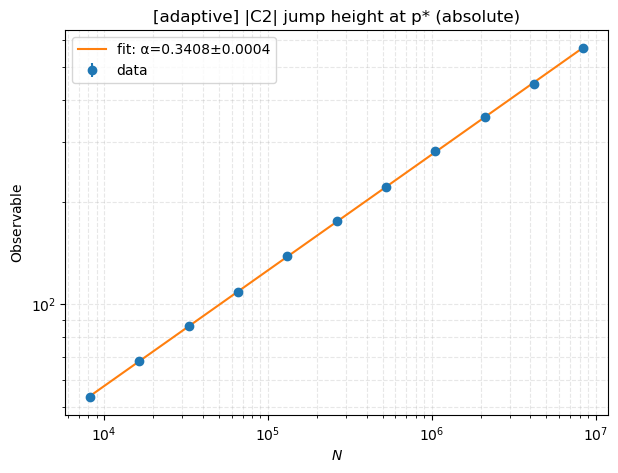

Saved plot to /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures/409.png


In [14]:
# Absolute jump height of |C2| at p*
core_jump_abs = au.extract_fss(stats_files, row=26, value_kind='mean')
if core_jump_abs.empty:
    print('No absolute core jump-height data found.')
else:
    core_jump_abs_fit = au.weighted_log_fit(core_jump_abs)
    print(core_jump_abs[['N', 'value', 'error']])
    print('Absolute |C2| jump-height fit:', core_jump_abs_fit)
    au.plot_fss_with_fit(core_jump_abs, core_jump_abs_fit, title=f"[{MODE}] |C2| jump height at p* (absolute)")


### 2-core Jump Height Effective Exponent


      N_left    N_right        N_geom  exponent  exponent_err
0     8192.0    65536.0  2.317048e+04  0.344350      0.001763
1    16384.0   131072.0  4.634095e+04  0.344117      0.001787
2    32768.0   262144.0  9.268190e+04  0.344365      0.001750
3    65536.0   524288.0  1.853638e+05  0.341892      0.001729
4   131072.0  1048576.0  3.707276e+05  0.339513      0.001766
5   262144.0  2097152.0  7.414552e+05  0.339328      0.001770
6   524288.0  4194304.0  1.482910e+06  0.336454      0.001736
7  1048576.0  8388608.0  2.965821e+06  0.335127      0.001769


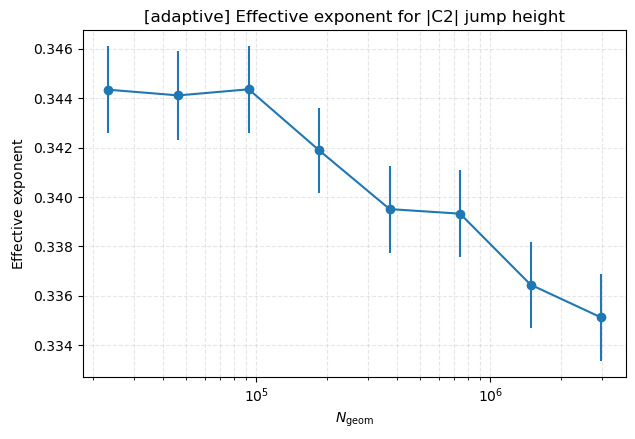

Saved plot to /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures/410.png


In [15]:
# Effective exponent for |C2| jump height
if core_jump_abs.empty:
    print('No absolute core jump-height data for effective exponents.')
else:
    eff_core_jump = au.compute_effective_exponents(core_jump_abs, window=EFFECTIVE_WINDOW)
    print(eff_core_jump)
    au.plot_effective_exponent(eff_core_jump, title=f"[{MODE}] Effective exponent for |C2| jump height")


## Pseudocritical points and $\bar{\nu}$ (from $\sigma(p_c)$ scaling)


[adaptive] sigma(pc) from p_plus (largest GC drop): nu_bar=2.7941±0.0134 (alpha=-0.3579±0.0017)


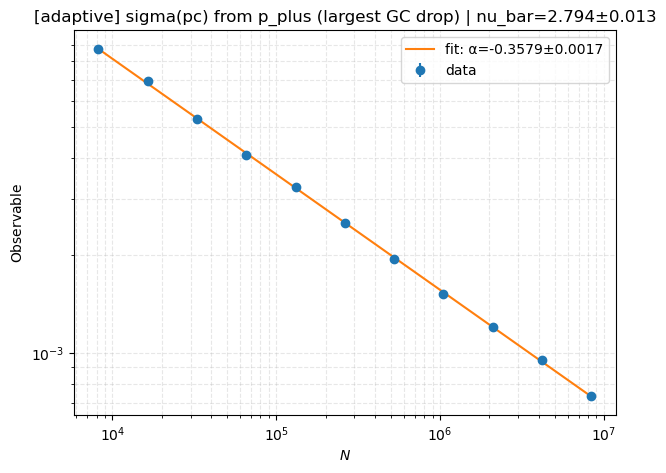

Saved plot to /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures/411.png


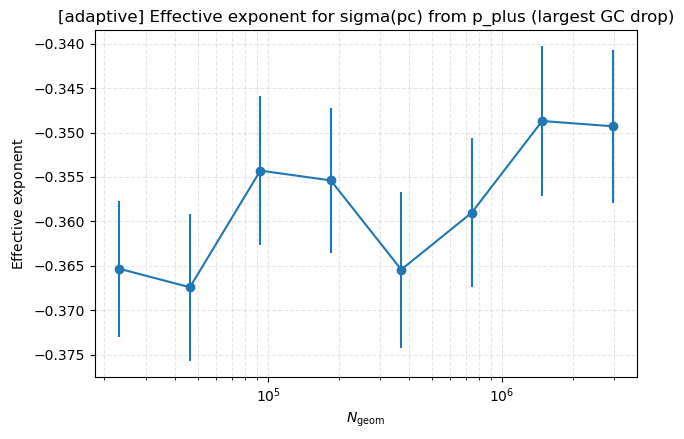

Saved plot to /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures/412.png
[adaptive] sigma(pc) from q_zero (max finite-cluster observable): nu_bar=2.7361±0.0133 (alpha=-0.3655±0.0018)


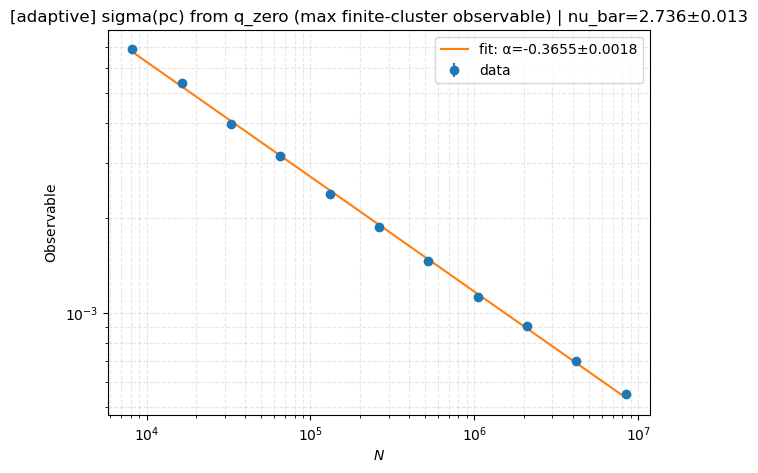

Saved plot to /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures/413.png


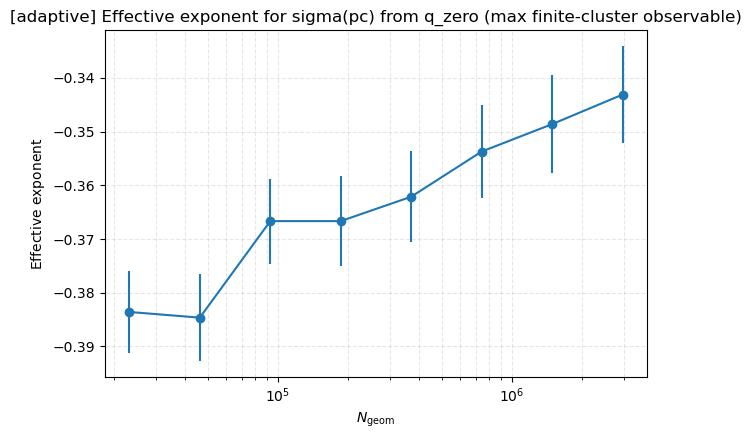

Saved plot to /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures/414.png
[adaptive] sigma(pc) from core_p_star (largest 2-core drop): nu_bar=1.9903±0.0039 (alpha=-0.5024±0.0010)


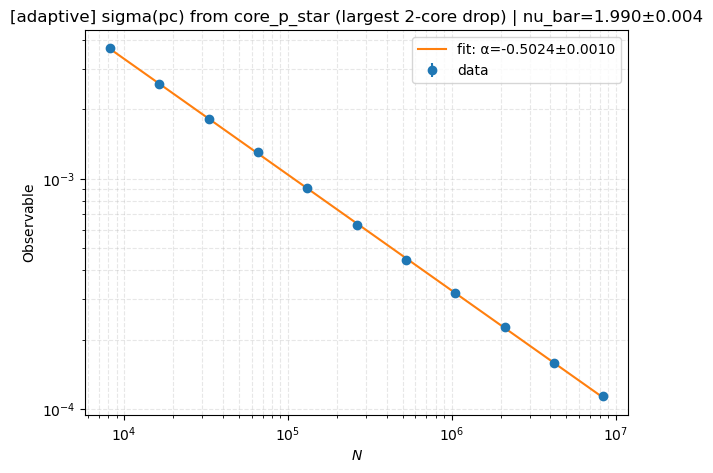

Saved plot to /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures/415.png


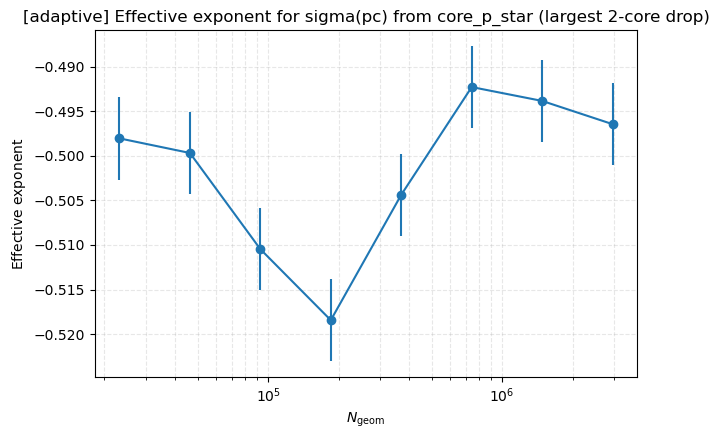

Saved plot to /nfs/nfs2/home/hanlsun/global_removal/link_percolation/figures/416.png


In [16]:
# Estimate
#   sigma(p_c) ~ N^{-1/nu_bar}  =>  alpha = -1/nu_bar  =>  nu_bar = -1/alpha

def _nu_bar_from_alpha(alpha: float, alpha_err: float):
    if alpha == 0 or not pd.notna(alpha):
        return float('nan'), float('nan')
    nu_bar = -1.0 / float(alpha)
    nu_bar_err = abs(float(alpha_err) / (float(alpha) ** 2))
    return nu_bar, nu_bar_err

PC_STD_OBS = [
    ('sigma(pc) from p_plus (largest GC drop)', 2),
    ('sigma(pc) from q_zero (max finite-cluster observable)', 13),
    ('sigma(pc) from core_p_star (largest 2-core drop)', 25),
]

for label, row in PC_STD_OBS:
    fss = au.extract_fss(stats_files, row=row, value_kind='std')
    if fss.empty:
        print(f'No data for {label}')
        continue
    fss = fss.loc[fss['value'] > 0].reset_index(drop=True)
    if fss.empty:
        print(f'All sigma values are non-positive for {label}; cannot log-fit.')
        continue
    fit = au.weighted_log_fit(fss)
    nu_bar, nu_bar_err = _nu_bar_from_alpha(fit['alpha'], fit['alpha_err'])
    print(f"[{MODE}] {label}: nu_bar={nu_bar:.4f}±{nu_bar_err:.4f} (alpha={fit['alpha']:.4f}±{fit['alpha_err']:.4f})")
    au.plot_fss_with_fit(fss, fit, title=f"[{MODE}] {label} | nu_bar={nu_bar:.3f}±{nu_bar_err:.3f}")

    eff = au.compute_effective_exponents(fss, window=EFFECTIVE_WINDOW)
    if not eff.empty:
        au.plot_effective_exponent(eff, title=f"[{MODE}] Effective exponent for {label}")
